In [23]:
####Imports and Setup
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import patsy
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
###########################
import numpy as np
import scipy 
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
# We are using the BernoulliNB version of Naive Bayes, which assumes predictors are binary encoded.
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score

from sklearn.linear_model import LogisticRegressionCV

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import enchant

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV

from sklearn.feature_extraction import stop_words

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

def update_columns(col_names, label):
    new_names = []
    new_names.append(col_names[0])
    for name in col_names[1:]:
        name = label + name
        new_names.append(name)
    return new_names

def is_ascii(column):
    column_list = []
    for col in column:
        for letter in col:
            if ord(letter) > 128:
                column_list.append(col)
                continue
    return column_list

def del_cols(df):
    cols = list(df.columns.values)
    cols_del = []
    for x in cols:
        for ch in x:
            if ch not in 'abcdefghijklmnopqrstuvwxyz_0123456789-':
                cols_del.append(x)
                continue
    return cols_del

def del_cols_lyric(df):
    cols = list(df.columns.values)
    cols_del = []
    for x in cols:
        for ch in x:
            if ch not in 'abcdefghijklmnopqrstuvwxyz_-':
                cols_del.append(x)
                continue
    return cols_del

def del_stopwords(df):
    stop = stopwords.words('english')
    cols = list(df.columns.values)
    cols_del = []
    for x in cols:
        if x in stop:
            cols_del.append(x)
    return cols_del

In [3]:
conn_addf_metadata = sqlite3.connect('../../Capstone/MillionSongSubset/AdditionalFiles/subset_track_metadata.db')

In [55]:
df_songs = pd.read_sql("SELECT * FROM songs", con=conn_addf_metadata)
df_genre_wide = pd.read_csv('../Capestone/df_genre_wide.csv') #key is 'track_id'

In [57]:
###Data Cleaning
df_genre_wide = df_genre_wide.drop('Unnamed: 0', axis=1)

In [58]:
###Data Merging
df_title_genre = pd.merge(df_songs, df_genre_wide, how='inner', on='track_id')

In [60]:
print df_songs.shape
print df_genre_wide.shape
print df_title_genre.shape

(10000, 11)
(133676, 14)
(1390, 24)


In [6]:
df_songs_pop = df_songs

In [45]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
track_id              10000 non-null object
title                 10000 non-null object
song_id               10000 non-null object
release               10000 non-null object
artist_id             10000 non-null object
artist_mbid           10000 non-null object
artist_name           10000 non-null object
duration              10000 non-null float64
artist_familiarity    10000 non-null float64
artist_hotttnesss     10000 non-null float64
year                  10000 non-null int64
popularity            10000 non-null int64
dtypes: float64(3), int64(2), object(7)
memory usage: 937.6+ KB


In [8]:
df_songs_pop.head(1)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRACCVZ128F4291A8A,Deep Sea Creature,SOVLGJY12A8C13FBED,Call of the Mastodon,ARMQHX71187B9890D3,bc5e2ad6-0a4a-4d90-b911-e9a7e6861727,Mastodon,280.21506,0.780462,0.574275,2001


In [7]:
df_songs_pop.columns

Index([u'track_id', u'title', u'song_id', u'release', u'artist_id',
       u'artist_mbid', u'artist_name', u'duration', u'artist_familiarity',
       u'artist_hotttnesss', u'year'],
      dtype='object')

In [10]:
df_songs_pop['popularity'] = df_songs_pop['artist_hotttnesss'].map(lambda x: 1 if x >= .6 else 0)

In [12]:
df_songs_pop['popularity'].value_counts()

0    9488
1     512
Name: popularity, dtype: int64

In [15]:
del_col = ['track_id', 'song_id', 'release', 
           'artist_id', 'artist_mbid', 'artist_name', 
           'duration', 'artist_familiarity', 'artist_hotttnesss', 'year']

In [16]:
df_songs_pop = df_songs_pop.drop(del_col, axis=1)

In [18]:
df_songs_pop.head(1)

,title,popularity
0,Deep Sea Creature,0


In [19]:
vect = CountVectorizer()
vect.fit(df_songs_pop['title'])
X_train = vect.transform(df_songs_pop['title']).toarray()

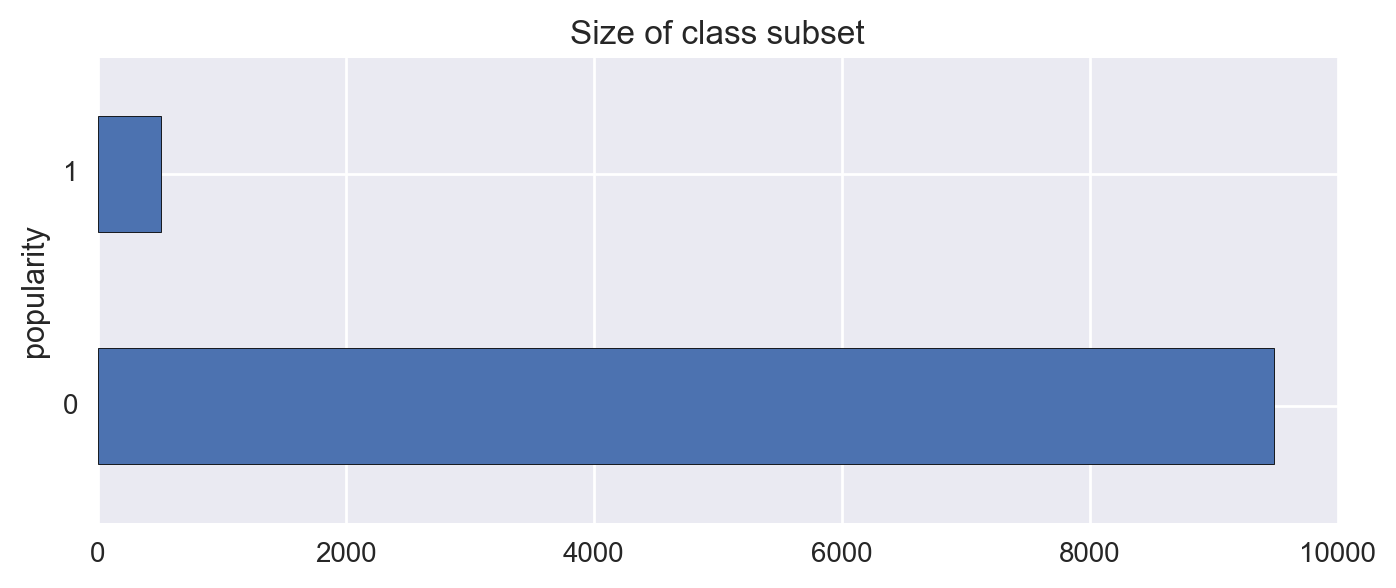

In [21]:
df_songs_pop.groupby("popularity").size().plot(kind="barh", title="Size of class subset", figsize=(8, 3))

In [24]:
my_stop_words = list(stop_words.ENGLISH_STOP_WORDS)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def plot_freq(data, vectorizer="tfidf", stopwords=None):
    
    if vectorizer == "tfidf":
        vect = TfidfVectorizer(stop_words=stopwords, sublinear_tf=False, use_idf=True, smooth_idf=True, )
    else:
        vect = CountVectorizer(stop_words=stopwords)
    
    X      =  vect.fit_transform(data)
    x_df   =  pd.DataFrame(X.toarray(), columns=vect.vocabulary_)
    tf_df  =  pd.DataFrame(x_df.mean(), columns=["freq"])
    
    title  =  "Frequency - Top 20: %s, Stopwords: %s" % (vectorizer, stopwords)
    
    tf_df.sort_values("freq").tail(20).plot(kind="barh", title=title, figsize=(10,5))

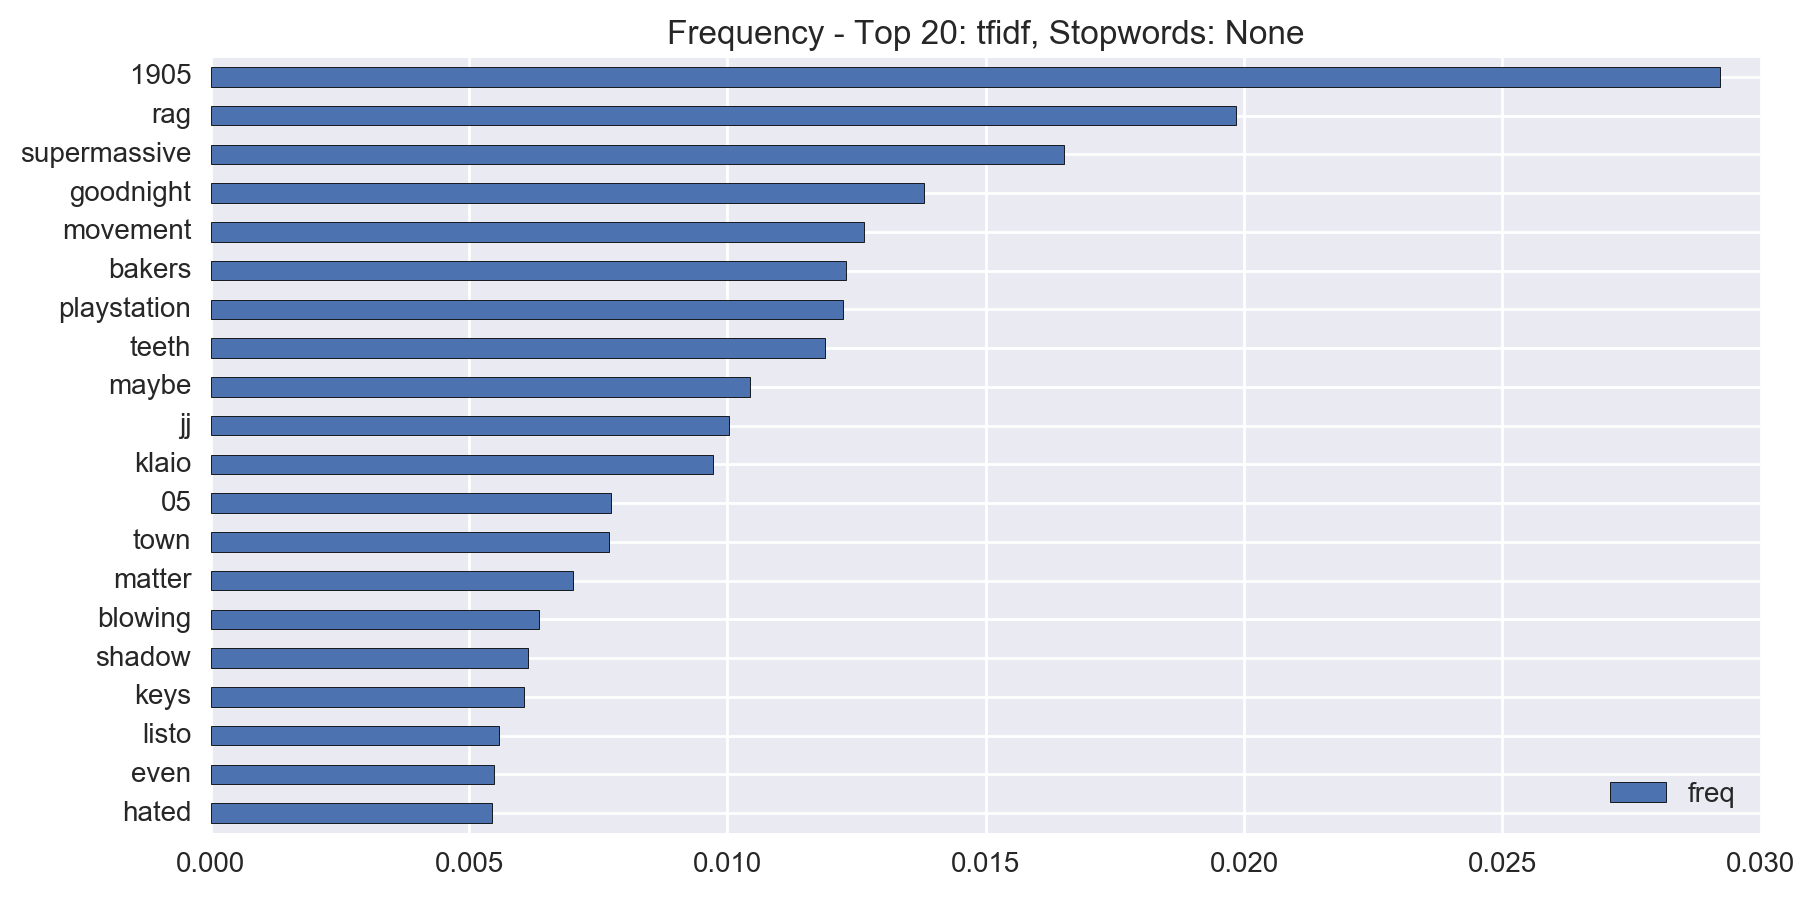

In [33]:
plot_freq(df_songs_pop['title'], vectorizer="tfidf", stopwords=None)

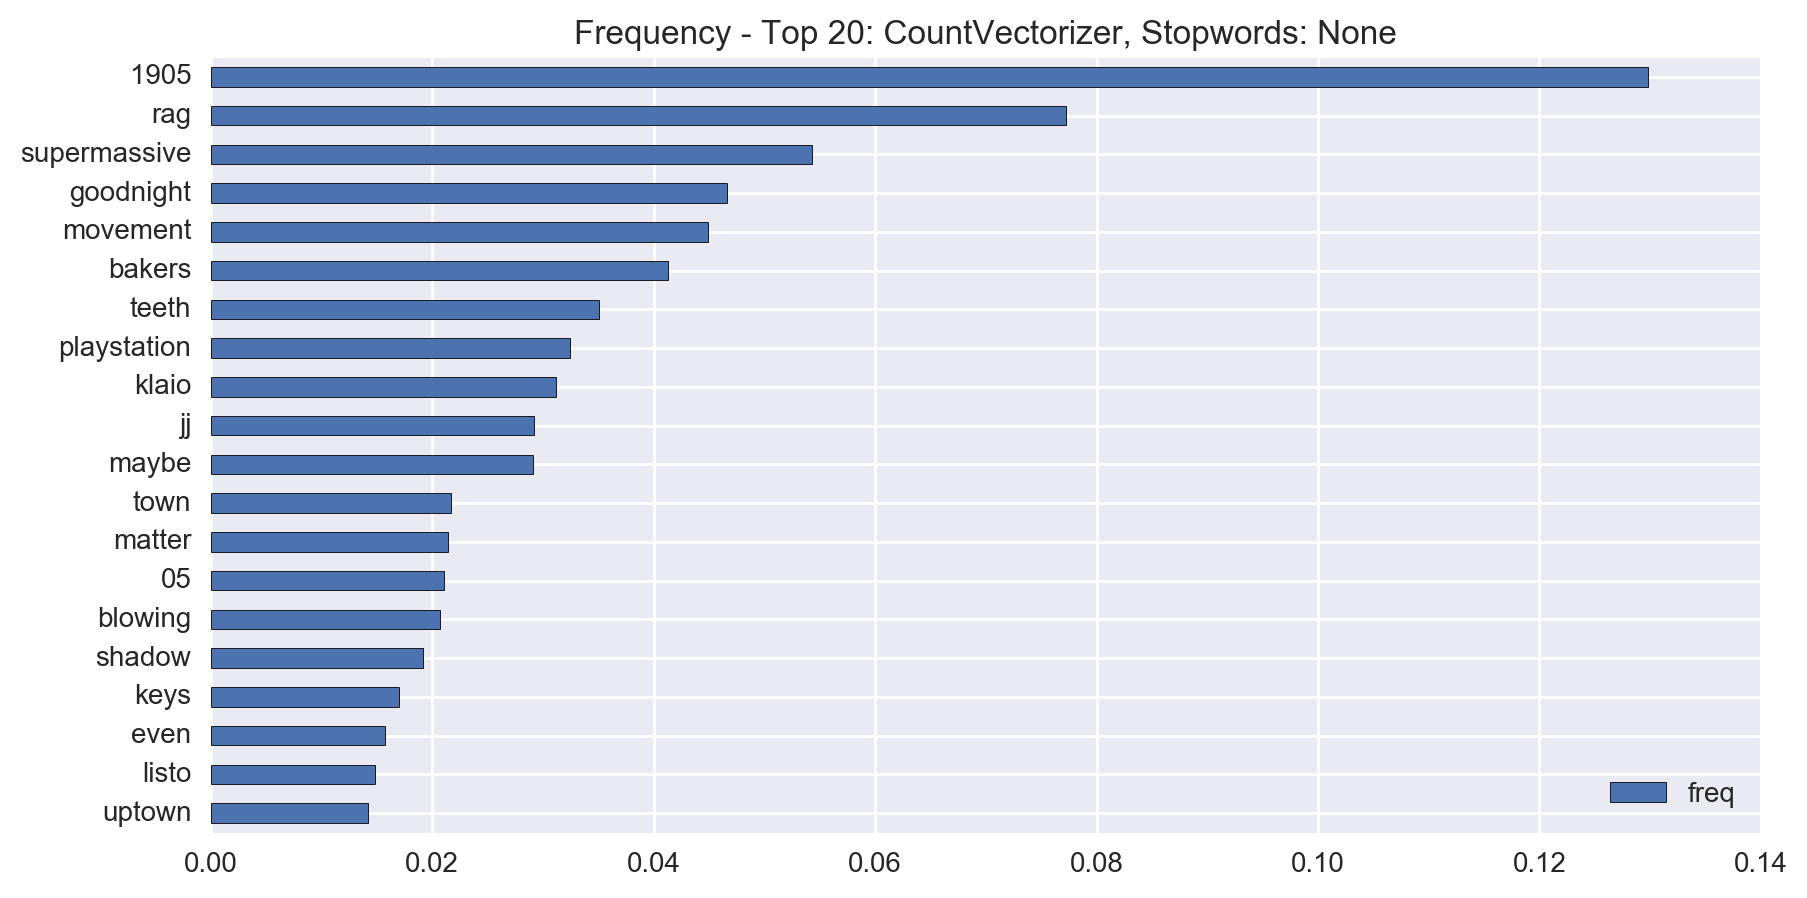

In [34]:
plot_freq(df_songs_pop['title'], vectorizer="CountVectorizer", stopwords=None)

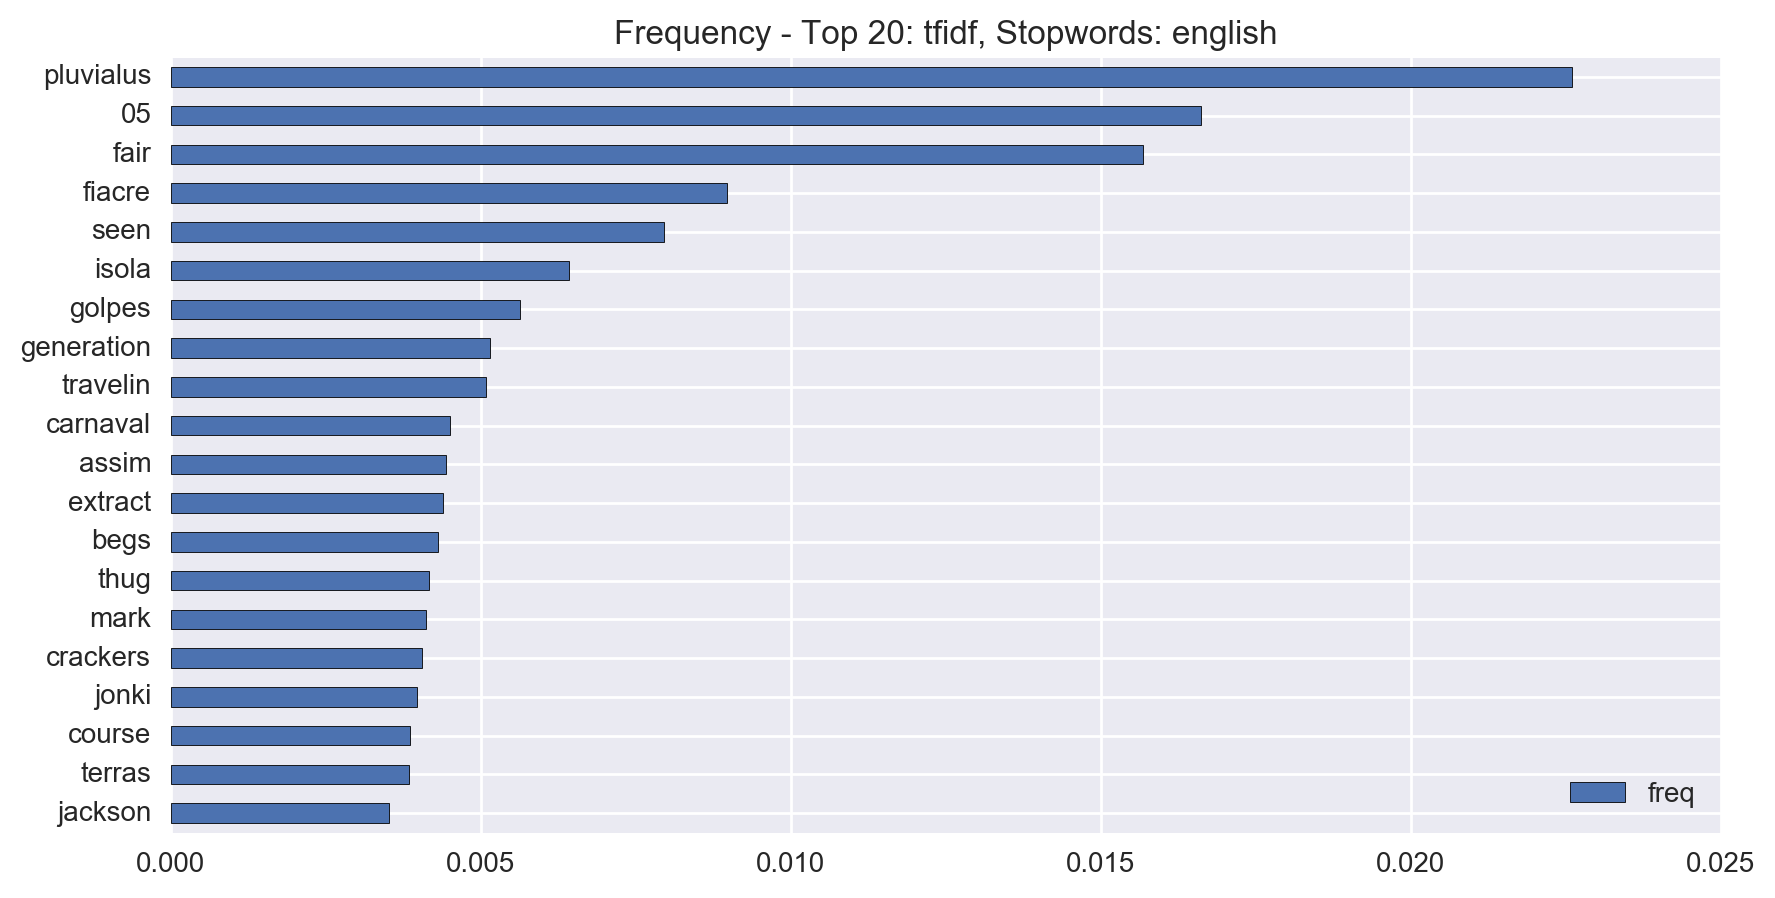

In [35]:
plot_freq(df_songs_pop['title'], vectorizer="tfidf", stopwords="english")

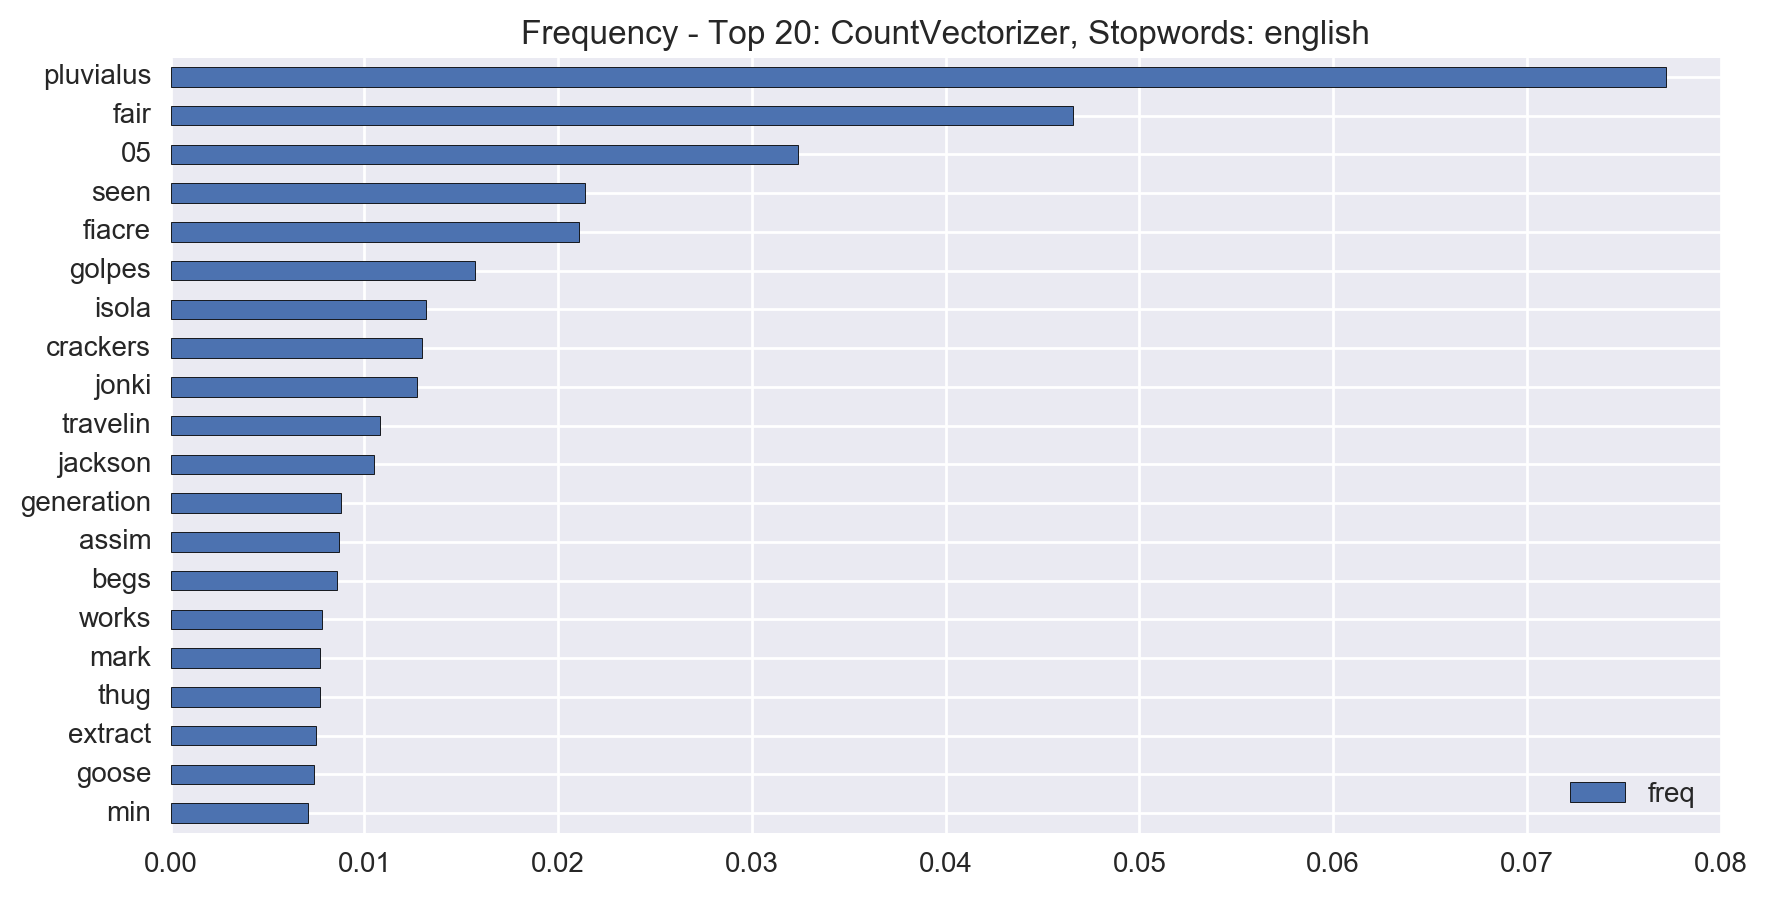

In [36]:
plot_freq(df_songs_pop['title'], vectorizer="CountVectorizer", stopwords="english")

In [54]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

cvec = CountVectorizer(stop_words='english')

X = cvec.fit_transform(df_songs_pop['title'])
y = df_songs_pop['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

lr.fit(X_train, y_train)
print 1-np.mean(y_test)
print lr.score(X_test, y_test)
print y_test.value_counts()

0.95303030303
0.952727272727
0    3145
1     155
Name: popularity, dtype: int64


In [ ]:
###Precision Recall:
##When you guess positive (popular) - how often am I right

# When I guess 1, what percentage of is it is 1 (precision)

# Reacll: of the 1, how many did I get it right

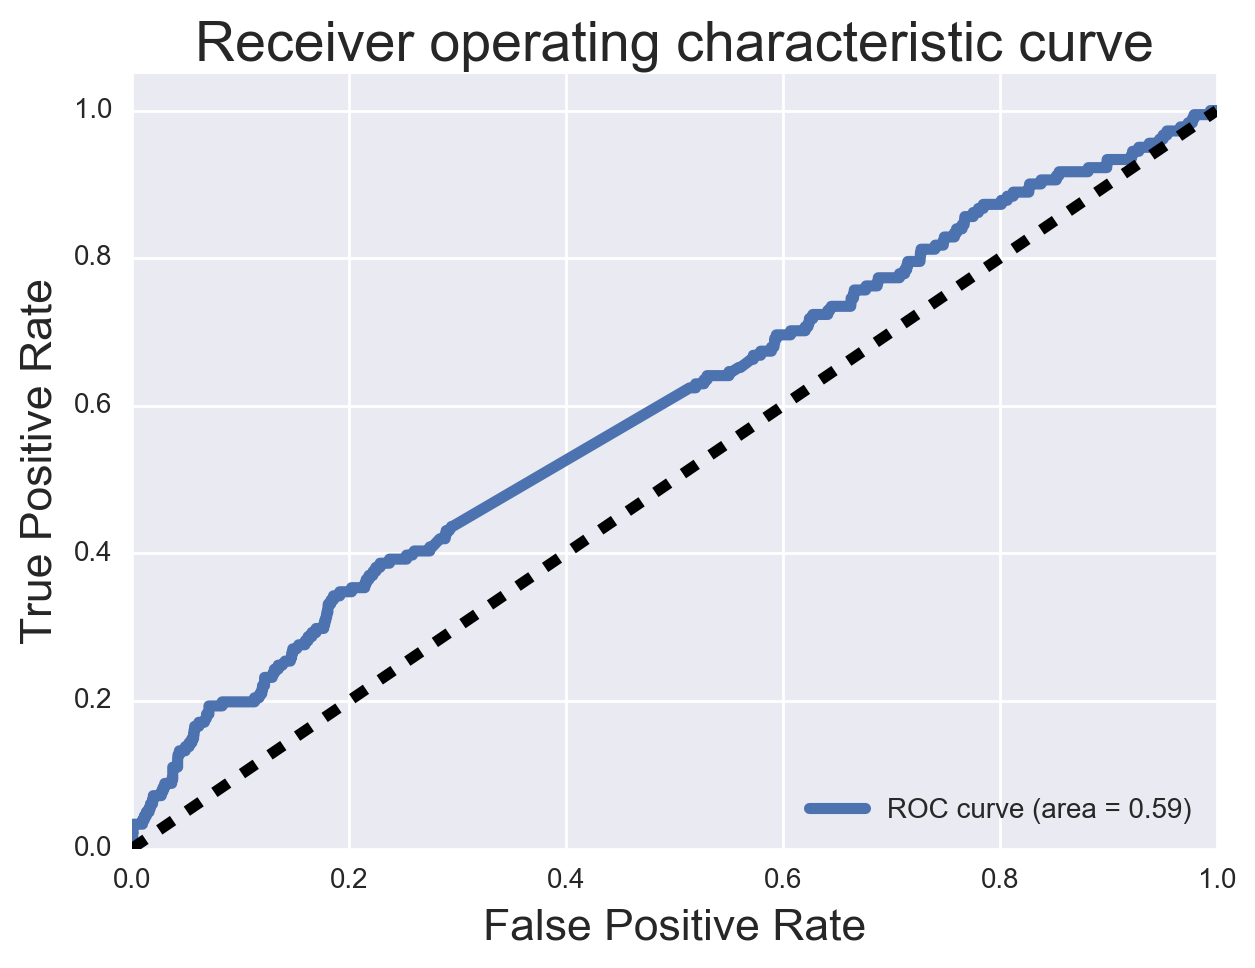

In [50]:
from sklearn.metrics import roc_curve, auc

# Get out the predicted probabilities for the X observation matrix
y_pp = lr.predict_proba(X_test)

# roc_curve returns the false positive rate and true positive rates as the threshold changes
# takes in the y and the predicted probabilities of the positive class from your model.
fpr, tpr, _ = roc_curve(y_test, y_pp[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[7,5])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic curve', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [51]:
# Preprocess our text data to Tfidf
tfv = TfidfVectorizer(lowercase=True, strip_accents='unicode')
X_all = tfv.fit_transform(df_songs_pop['title'])
y_all = df_songs_pop['popularity']

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.33)

# Setup logistic regression (or try another classification method here)
estimator = LogisticRegression()
estimator.fit(X_train_all, y_train_all)
print 1-np.mean(y_test_all)
print estimator.score(X_test_all, y_test_all)

0.944848484848
0.944848484848


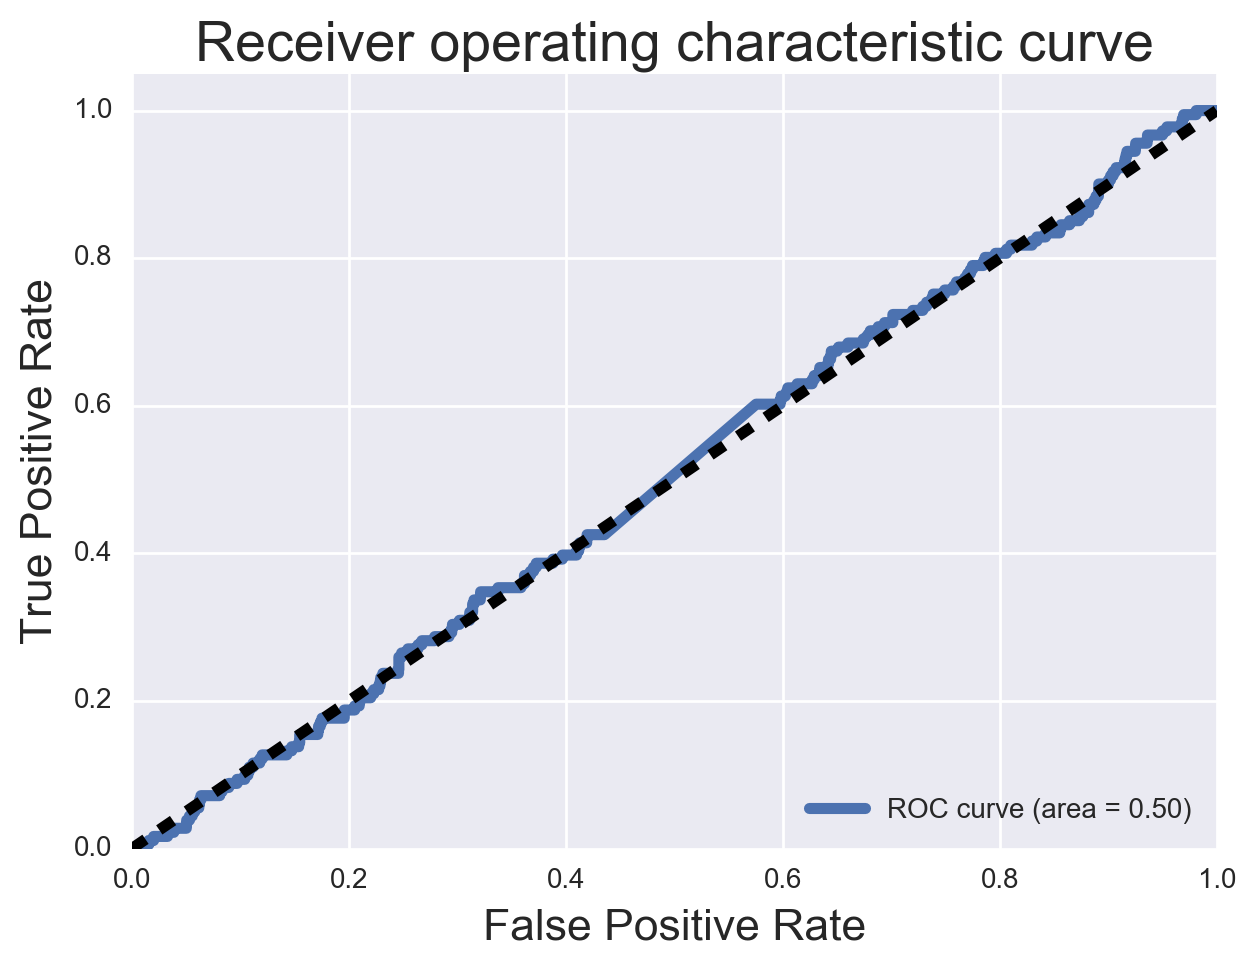

In [53]:
from sklearn.metrics import roc_curve, auc

# Get out the predicted probabilities for the X observation matrix
y_pp = estimator.predict_proba(X_test_all)

# roc_curve returns the false positive rate and true positive rates as the threshold changes
# takes in the y and the predicted probabilities of the positive class from your model.
fpr, tpr, _ = roc_curve(y_test, y_pp[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[7,5])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic curve', fontsize=20)
plt.legend(loc="lower right")
plt.show()